# Import supporting package

In [1]:
import xarray as xr
import numpy as np
import copy

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=14, threads_per_worker=4, processes=True, memory_limit='60GB')
client

<Client: 'tcp://127.0.0.1:54873' processes=14 threads=56, memory=782.31 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + "2023/05/09" # get_date()

# Check the stability of our BEC

The detected scaning axes and values are: 

{'runs': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.

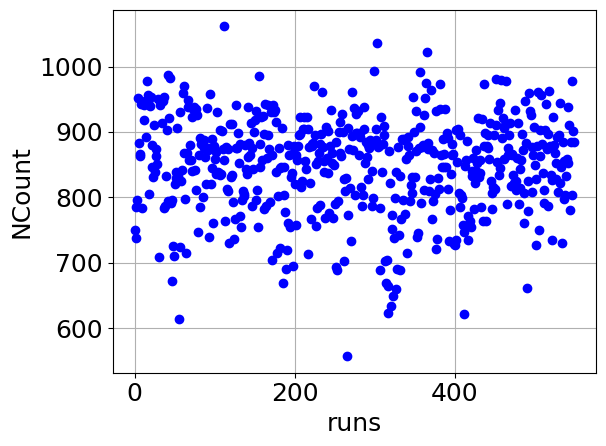

In [5]:
shotNum = "0007"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetOfGlobalDict = {
    dskey[groupList[i]]: read_hdf5_global(filePath, groupList[i])
    for i in [0]
}

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i], datesetOfGlobal=dataSetOfGlobalDict[dskey[groupList[i]]])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)
dataSet = swap_xy(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (959, 876)
imageAnalyser.span = (100, 100)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD).load()

fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
dataSet_cropOD = auto_rechunk(dataSet_cropOD)

fitAnalyser = FitAnalyser("Two Gaussian-2D", fitDim=2)
params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params, dask="parallelized").load()

fitValue = fitAnalyser.get_fit_value(fitResult)
fitStd = fitAnalyser.get_fit_std(fitResult)

In [ ]:
BEC_Ncount_val = fitValue['A_amplitude']
BEC_Ncount_std = fitStd['A_amplitude']

thermal_Ncount_val = fitValue['B_amplitude']
thermal_Ncount_std = fitStd['B_amplitude']

BEC_width_x_val = fitValue['A_sigmax']
BEC_width_x_std = fitStd['A_sigmax']
BEC_width_y_val = fitValue['A_sigmay']
BEC_width_y_std = fitStd['A_sigmay']

thermal_width_x_val = fitValue['B_sigmax']
thermal_width_x_std = fitStd['B_sigmax']
thermal_width_y_val = fitValue['B_sigmay']
thermal_width_y_std = fitStd['B_sigmay']

BEC_center_x_val = fitValue['A_centerx']
BEC_center_x_std = fitStd['A_centerx']
BEC_center_y_val = fitValue['A_centery']
BEC_center_y_std = fitStd['A_centery']

thermal_center_x_val = fitValue['B_centerx']
thermal_center_x_std = fitStd['B_centerx']
thermal_center_y_val = fitValue['B_centery']
thermal_center_y_std = fitStd['B_centery']

In [ ]:
total_Ncount_val = BEC_Ncount_val + thermal_Ncount_val
total_Ncount_std = BEC_Ncount_std + thermal_Ncount_std

fig = plt.figure()
ax = fig.gca()

total_Ncount_val.plot.errorbar(ax=ax, yerr=total_Ncount_std, fmt='ob')
# plt.ylim([0, 1100])
plt.ylabel('Ncount from fit')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

print(total_Ncount_val.mean())

In [ ]:
fig = plt.figure()
ax = fig.gca()

BEC_Ncount_val.plot.errorbar(ax=ax, yerr=BEC_Ncount_std, fmt='ob')
plt.ylim([0, 750])
plt.ylabel('Ncount of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_Ncount_val.plot.errorbar(ax=ax, yerr=thermal_Ncount_std, fmt='or')
plt.ylim([0, 500])
plt.ylabel('Ncount of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

BEC_width_x_val.plot.errorbar(ax=ax, yerr=BEC_width_x_std, fmt='ob')

plt.ylabel('X-axis Width of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

BEC_width_y_val.plot.errorbar(ax=ax, yerr=BEC_width_y_std, fmt='ob')

plt.ylabel('Y-axis Width of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_x_val.plot.errorbar(ax=ax, yerr=thermal_width_x_std, fmt='or')

plt.ylabel('X-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_y_val.plot.errorbar(ax=ax, yerr=thermal_width_y_std, fmt='or')

plt.ylabel('Y-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

BEC_center_x_val.plot.errorbar(ax=ax, yerr=BEC_center_x_std, fmt='ob')

plt.ylabel('X-axis center of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

BEC_center_y_val.plot.errorbar(ax=ax, yerr=BEC_center_y_std, fmt='ob')

plt.ylabel('Y-axis center of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_x_val.plot.errorbar(ax=ax, yerr=thermal_center_x_std, fmt='or')

plt.ylabel('X-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_y_val.plot.errorbar(ax=ax, yerr=thermal_center_y_std, fmt='or')

plt.ylabel('Y-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fitFullResult = fitAnalyser.get_fit_full_result(fitResult)
condensateFraction = fitFullResult['A_amplitude'] / (fitFullResult['A_amplitude'] + fitFullResult['B_amplitude'])
condensateFraction_value, condensateFraction_std = seperate_uncertainty(condensateFraction)

fig = plt.figure()
ax = fig.gca()

condensateFraction_value.plot.errorbar(ax=ax, yerr=condensateFraction_std, fmt='ob')

plt.ylabel('Condensate Fraction')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
val = Ncount.mean().item()
std = Ncount.std().item()
print(f'The total Ncount is: {val: .2f} \u00B1 {std: .2f}')

val = total_Ncount_val.mean().item()
std = total_Ncount_val.std().item()
print(f'The total Ncount from fit is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_Ncount_val.mean().item()
std = BEC_Ncount_val.std().item()
print(f'The Ncount of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_Ncount_val.mean().item()
std = thermal_Ncount_val.std().item()
print(f'The Ncount of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_width_x_val.mean().item()
std = BEC_width_x_val.std().item()
print(f'The x-axis width of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_width_y_val.mean().item()
std = BEC_width_y_val.std().item()
print(f'The y-axis width of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_x_val.mean().item()
std = thermal_width_x_val.std().item()
print(f'The x-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_y_val.mean().item()
std = thermal_width_y_val.std().item()
print(f'The y-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_center_x_val.mean().item()
std = BEC_center_x_val.std().item()
print(f'The x-axis center of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_center_y_val.mean().item()
std = BEC_center_y_val.std().item()
print(f'The y-axis center of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_x_val.mean().item()
std = thermal_center_x_val.std().item()
print(f'The x-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_y_val.mean().item()
std = thermal_center_y_val.std().item()
print(f'The y-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = condensateFraction_value.mean().item()
std = condensateFraction_value.std().item()
print(f'The condensate fraction is: {val: .4f} \u00B1 {std: .4f}')

In [7]:
i=0
da_test = read_hdf5_run_time(filePath, datesetOfGlobal=dataSetOfGlobalDict[dskey[groupList[i]]])

In [8]:
da_test

<xarray.Dataset>
Dimensions:  (runs: 550)
Coordinates:
  * runs     (runs) float64 0.0 1.0 2.0 3.0 4.0 ... 546.0 547.0 548.0 549.0
Data variables:
    runTine  (runs) datetime64[ns] 2023-05-09T14:30:03 ... 2023-05-09T15:56:53
Attributes: (12/101)
    TOF_free:                          0.02
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    runs:                              [  0.   1.   2.   3.   4.   5.   6.   ...
    scanAxis:                          ['runs']
    scanAxisLength:                    [550.]

In [ ]:
filepath = '//DyLabNAS/Data/Evaporative_Cooling/2023/05/09/0007/2023-05-09_0007_Evaporative_Cooling_549.h5'

## Close to the BEC transition point, in evaporative cooling 2 with truncation value = 0.77

In [ ]:
shotNum = "0015"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (879, 956)
imageAnalyser.span = (200, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD).load()

fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')
plt.ylim([0, 3000])
plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
dataSet_cropOD = auto_rechunk(dataSet_cropOD)

fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)
params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params, dask="parallelized").load()

fitValue = fitAnalyser.get_fit_value(fitResult)
fitStd = fitAnalyser.get_fit_std(fitResult)

In [ ]:
thermal_Ncount_val = fitValue['amplitude']
thermal_Ncount_std = fitStd['amplitude']

thermal_width_x_val = fitValue['sigmax']
thermal_width_x_std = fitStd['sigmax']
thermal_width_y_val = fitValue['sigmay']
thermal_width_y_std = fitStd['sigmay']

thermal_center_x_val = fitValue['centerx']
thermal_center_x_std = fitStd['centerx']
thermal_center_y_val = fitValue['centery']
thermal_center_y_std = fitStd['centery']

In [ ]:
total_Ncount_val = thermal_Ncount_val
total_Ncount_std = thermal_Ncount_std

fig = plt.figure()
ax = fig.gca()

total_Ncount_val.plot.errorbar(ax=ax, yerr=total_Ncount_std, fmt='ob')
plt.ylim([0, 3000])
plt.ylabel('Ncount from fit')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_x_val.plot.errorbar(ax=ax, yerr=thermal_width_x_std, fmt='or')

plt.ylabel('X-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_y_val.plot.errorbar(ax=ax, yerr=thermal_width_y_std, fmt='or')

plt.ylabel('Y-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_x_val.plot.errorbar(ax=ax, yerr=thermal_center_x_std, fmt='or')

plt.ylabel('X-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_y_val.plot.errorbar(ax=ax, yerr=thermal_center_y_std, fmt='or')

plt.ylabel('Y-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
val = Ncount.mean().item()
std = Ncount.std().item()
print(f'The total Ncount is: {val: .2f} \u00B1 {std: .2f}')

val = total_Ncount_val.mean().item()
std = total_Ncount_val.std().item()
print(f'The total Ncount from fit is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_x_val.mean().item()
std = thermal_width_x_val.std().item()
print(f'The x-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_y_val.mean().item()
std = thermal_width_y_val.std().item()
print(f'The y-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_x_val.mean().item()
std = thermal_center_x_val.std().item()
print(f'The x-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_y_val.mean().item()
std = thermal_center_y_val.std().item()
print(f'The y-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

## At the end of ODT loading

In [ ]:
shotNum = "0020"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (550, 800)
imageAnalyser.span = (900, 1600)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD).load()

fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
dataSet

In [ ]:
fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')
plt.ylim([0, 150000])
plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
dataSet_cropOD = dataSet_cropOD.chunk((1, 900, 1600))
dataSet_cropOD

In [ ]:
# dataSet_cropOD = auto_rechunk(dataSet_cropOD)

fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)
params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params, dask="parallelized").load()

fitValue = fitAnalyser.get_fit_value(fitResult)
fitStd = fitAnalyser.get_fit_std(fitResult)

In [ ]:
thermal_Ncount_val = fitValue['amplitude']
thermal_Ncount_std = fitStd['amplitude']

thermal_width_x_val = fitValue['sigmax']
thermal_width_x_std = fitStd['sigmax']
thermal_width_y_val = fitValue['sigmay']
thermal_width_y_std = fitStd['sigmay']

thermal_center_x_val = fitValue['centerx']
thermal_center_x_std = fitStd['centerx']
thermal_center_y_val = fitValue['centery']
thermal_center_y_std = fitStd['centery']

In [ ]:
total_Ncount_val = thermal_Ncount_val
total_Ncount_std = thermal_Ncount_std

fig = plt.figure()
ax = fig.gca()

total_Ncount_val.plot.errorbar(ax=ax, yerr=total_Ncount_std, fmt='ob')
plt.ylim([0, 160000])
plt.ylabel('Ncount from fit')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_x_val.plot.errorbar(ax=ax, yerr=thermal_width_x_std, fmt='or')

plt.ylabel('Y-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_y_val.plot.errorbar(ax=ax, yerr=thermal_width_y_std, fmt='or')

plt.ylabel('X-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_x_val.plot.errorbar(ax=ax, yerr=thermal_center_x_std, fmt='or')

plt.ylabel('Y-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_y_val.plot.errorbar(ax=ax, yerr=thermal_center_y_std, fmt='or')

plt.ylabel('X-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
val = Ncount.mean().item()
std = Ncount.std().item()
print(f'The total Ncount is: {val: .2f} \u00B1 {std: .2f}')

val = total_Ncount_val.mean().item()
std = total_Ncount_val.std().item()
print(f'The total Ncount from fit is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_x_val.mean().item()
std = thermal_width_x_val.std().item()
print(f'The y-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_y_val.mean().item()
std = thermal_width_y_val.std().item()
print(f'The x-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_x_val.mean().item()
std = thermal_center_x_val.std().item()
print(f'The y-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_y_val.mean().item()
std = thermal_center_y_val.std().item()
print(f'The x-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

In [ ]:
l = list(np.arange(0.001, 0.025, 0.0005))
# l = np.logspace(np.log10(100e-3), np.log10(20), num=20)

l = [round(item, 7) for item in l]
#random.shuffle(l)

print(l)
print(len(l))
np.mean(l)

## ODT 1 Calibration

In [ ]:
v_high = 2.7
"""High Power"""
P_arm1_high = 5.776 * v_high - 0.683

v_mid = 0.2076
"""Intermediate Power"""
P_arm1_mid = 5.815 * v_mid - 0.03651

v_low = 0.0587
"""Low Power"""
P_arm1_low = 5271 * v_low - 27.5

print(round(P_arm1_high, 3))
print(round(P_arm1_mid, 3))
print(round(P_arm1_low, 3))

## ODT 2 Power Calibration

In [ ]:
v = 0.7607
P_arm2 = 2.302 * v - 0.06452
print(round(P_arm2, 3))